In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
if 'init_modules' in globals():
    for m in [x for x in sys.modules.keys() if x not in init_modules]:
        del(sys.modules[m]) 
else:
    init_modules = sys.modules.keys()

from math import *
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.stats import ortho_group
from scipy.interpolate import griddata
import importlib

np.set_printoptions(precision=7)

In [2]:
from chemistry import *
from chemistry.utils import linalg
from chemistry.functions import GaussianWrapper
from chemistry.optimization import GradientDescent, delta_strategies, stop_strategies

importlib.reload(functions)
importlib.reload(optimization)
importlib.reload(stop_strategies)
importlib.reload(delta_strategies)

<module 'chemistry.optimization.delta_strategies' from '/home/george/work/np-complete/study/au/python_chemistry/chemistry/optimization/delta_strategies/__init__.py'>

In [3]:
molecule, struct = functions.Molecule.load_chemcraft_file('./work/C2H4.xyz')
# molecule, struct = functions.Molecule.load_chemcraft_file('./work/H2O.xyz')

path = optimization.optimize_structure_rfo(molecule, struct, 
                                           delta_strategies.RFO(0), 
                                           stop_strategies.GradNorm(1e-5))

/home/george/work/np-complete/study/au/python_chemistry/chemistry/utils/linalg.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  new_dir = new_dir - basis[:, :i].dot(np.linalg.lstsq(basis[:, :i], new_dir)[0])




new iteration
value = -78.16104895722424, grad norm = 1.8266706864666275e-06, delta norm = 2.3035651247619938e-06
delta norm = 2.3035651247619938e-06 [[-1.5754451e-07 -8.9177984e-08  3.2221325e-07  6.3165802e-07
  3.2012007e-07  1.7332699e-06  5.2417193e-07 -6.2295079e-07
  2.9437699e-07 -4.4333662e-07  2.5348360e-07  8.0860479e-07]]
break


In [22]:
eq = path[-1]
print(molecule.grad(eq))
normalized = utils.linalg.get_normal_coordinate(molecule, eq)

[ 4.9045754e-07  7.1105720e-07  6.7127943e-07 -5.3047337e-07
 -2.9567308e-07 -2.5521107e-07  3.9728660e-08  2.0554816e-08
 -3.4550088e-07 -4.6223738e-07 -7.5920902e-07 -1.1139499e-07
  3.3076442e-07  6.9764197e-07  1.3838319e-07  1.3176011e-07
 -3.7437189e-07 -9.7555682e-08]


/home/george/work/np-complete/study/au/python_chemistry/chemistry/utils/linalg.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  new_dir = new_dir - basis[:, :i].dot(np.linalg.lstsq(basis[:, :i], new_dir)[0])


In [23]:
def sample_on_sphere(func, max_r, n_r, n_phi):
    vects = []
    values = []
    for axis_num in range(3):
        for r in np.linspace(0, max_r, n_r)[1:]:
            for phi in np.linspace(0, 2 * pi, n_phi):
                for sign in [-1, 1]:
                    x = r * cos(phi)
                    y = r * sin(phi)
                    z = sign * np.sqrt(abs(max_r**2 - x**2 - y**2))

                    vect = np.array([x, y, z])
                    vect = np.roll(vect, axis_num)
                    vects.append(vect)
                    values.append(normalized(vect))
        
    return vects, values

def plot_in_polar(phis, rs, vs, ax, n_grid=100, is_contour=False):
    max_r = np.max(rs)

    grid_phi = np.linspace(0.0, 2 * pi, n_grid)
    grid_r = np.linspace(0, 2 * pi, n_grid)
    grid_phi, grid_r = np.meshgrid(grid_phi, grid_r)

    data = griddata((phis, rs / np.max(rs) * 2 * pi), vs, (grid_phi, grid_r), method='cubic')
    grid_r = .5 * max_r * grid_r / pi

    if is_contour:
        ax.contour(grid_phi, grid_r, data, 200)
    else:
        ax.pcolormesh(grid_phi, grid_r, data)
    
def global_to_polar(vects, axis_num, orient, r_eps=1e-7):
    phis = []
    rs = []
    inds = []
    
    for i, vect in enumerate(vects):
        if orient * vect[axis_num] < 0:
            continue

        vect = np.array([vect[(axis_num + 1) % 3], vect[(axis_num + 2) % 3]])

        if abs(np.linalg.norm(vect)) < r_eps:
            continue

        phis.append(atan2(vect[1], vect[0]))
        if phis[-1] < 0:
            phis[-1] += 2 * pi
        rs.append(np.linalg.norm(vect))
        inds.append(i)
        
    return phis, rs, inds

    
def plot_all_spheres(vects, values, r_eps=1e-7, title=None, n_grid=100, is_contour=False, **fig_kw):
    fig, axs = plt.subplots(3, 2, subplot_kw={'projection': 'polar'}, **fig_kw)
    plt.suptitle(title)
    
    for axis_num in range(3):
        for orient_num, orient in enumerate([1, -1]):
            phis, rs, inds = global_to_polar(vects, axis_num, orient, r_eps)
            vs = [values[i] for i in inds]

            value = vs[np.argmin(rs)]
            for phi in set(phis):
                phis.append(phi)
                rs.append(0)
                vs.append(value)

            phis = np.array(phis)
            vs = np.array(vs)
            rs = np.array(rs)
            axs[axis_num][orient_num].set_title('{}'.format(orient * utils.linalg.eye(3, axis_num)))
            plot_in_polar(phis, rs, vs, axs[axis_num][orient_num], n_grid, is_contour)
            
    return axs

def plot_path(axs, path, c='r'):
    for axis_num, ax_row in enumerate(axs):
        for orient_num, ax in enumerate(ax_row):
            phis, rs, inds = global_to_polar(path, axis_num, 1 - orient_num * 2)
            if len(phis):
                ax.plot(phis, rs, c=c)
                ax.scatter(phis, rs)                
                if inds[-1] == len(path) - 1:
                    ax.scatter(phis[-1:], rs[-1:])

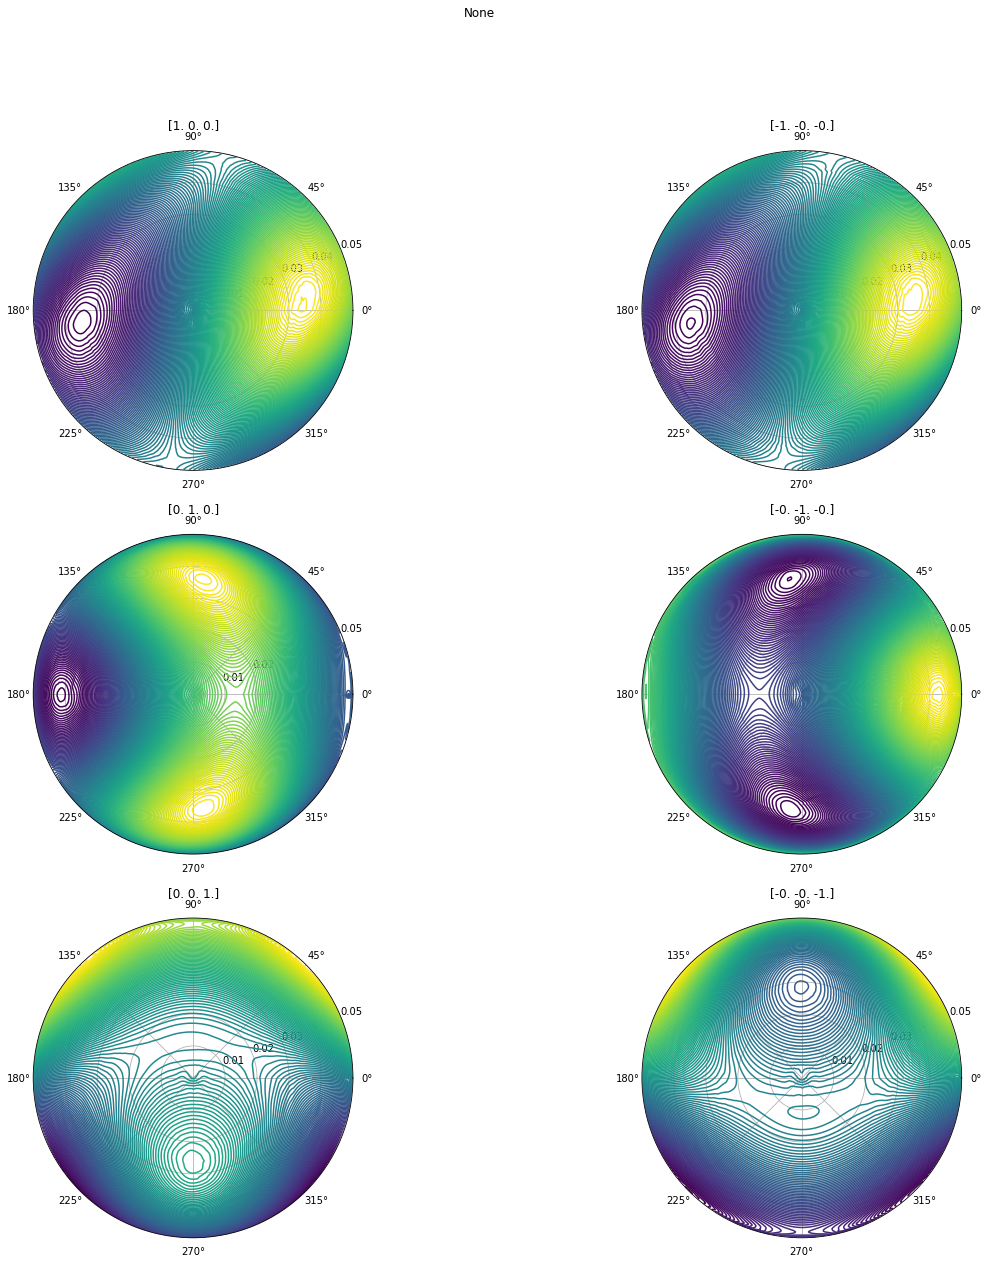

In [10]:
MAX_R = .05
N_PHI = 20
N_R = 20
vects, values = sample_on_sphere(molecule, MAX_R, N_R, N_PHI)
axs = plot_all_spheres(vects, values, figsize=(20, 20), n_grid=250, is_contour=True)

In [26]:
MAX_R = .05

known_directions = []

for i in range(10):
    seed = random.randint(0, 2**30)
    np.random.seed(seed)
    print('RANDOM SEED = {}'.format(seed))

    #     dir = np.array([1, -1, .3])
    dir = np.random.randn(normalized.n_dims)
    dir = dir / np.linalg.norm(dir) * MAX_R
    path = optimization.optimize_on_sphere_rfo(normalized, MAX_R, dir, 
                                                         delta_strategies.RFO(0), 
                                                         stop_strategies.GradNorm(1e-8))

    dir = path[-1]
    flag = True
    for known_dir in known_directions:
        dot = known_dir.dot(dir) / np.linalg.norm(known_dir) / np.linalg.norm(dir)
        if dot > .99:
            print('KNOWN DIRECTION: angle = {}, dot = {}'.format(acos(dot), dot))
            flag = False
            break
        else:
            print('from previous: angle = {}, dot = {}'.format(acos(dot), dot))
    if flag:
        known_directions.append(dir)
        
print()
print('Found directions:')

for dir in known_directions:
    print(dir)     

RANDOM SEED = 309822337


new iteration
value = -78.15980897618175, grad norm = 0.0001345827458127483, delta norm = 3.9760491142136685
delta norm = 3.9760491142136685
expected = -0.00230972933109315, real = -2.1494395440413427e-05, d = 0.9906939764971333

delta norm = 1.9880245571068342
expected = -0.0006461376075156546, real = -1.5860996455785425e-05, d = 0.9754526028646288

delta norm = 0.9940122785534171
expected = -0.00019588703925009726, real = -7.464056778871964e-05, d = 0.6189611723447264

delta norm = 0.49700613927670856
expected = -6.614807849811613e-05, real = -5.1889328375409605e-05, d = 0.215558039574991



new iteration
value = -78.15986086550964, grad norm = 0.00014745225333815, delta norm = 0.6548105765891845
delta norm = 0.6548105765891845
expected = -6.617846488518454e-05, real = -4.150578183725884e-05, d = 0.37282041961431484

delta norm = 0.32740528829459226
expected = -3.970374809562177e-05, real = -3.56364284641586e-05, d = 0.10244170453800767



new iteration
valu



new iteration
value = -78.15980672700984, grad norm = 0.0002315289467612406, delta norm = 2.2656345101819455
delta norm = 2.2656345101819455
expected = -0.0009089323667443852, real = 3.557514521901339e-05, d = 1.0391394855333806

delta norm = 1.1328172550909728
expected = -0.0003013336612354505, real = -5.48631179668746e-05, d = 0.8179323287616159

delta norm = 0.5664086275454864
expected = -0.00011238370008353975, real = -7.470419278376994e-05, d = 0.3352755539438635

delta norm = 0.2832043137727432
expected = -4.662106740822349e-05, real = -4.193067859148414e-05, d = 0.10060663724554743



new iteration
value = -78.15984865768857, grad norm = 0.00021967278065203715, delta norm = 0.7139246892483551
delta norm = 0.7139246892483551
expected = -9.809896070348836e-05, real = -4.553122920469832e-05, d = 0.5358643060213455

delta norm = 0.35696234462417753
expected = -5.7014542932539564e-05, real = -4.831996457710375e-05, d = 0.15249755427704417



new iteration
value = -78.15989697765315



new iteration
value = -78.15988864647093, grad norm = 7.954950452395231e-06, delta norm = 0.064016744044506
delta norm = 0.064016744044506
expected = -1.8480767855371136e-07, real = -1.8326169026749994e-07, d = 0.008365389892401574



new iteration
value = -78.15988882973255, grad norm = 7.466637779699446e-07, delta norm = 0.0028703804405218122
delta norm = 0.0028703804405218122
expected = -6.837996280109611e-10, real = -6.835705335106468e-10, d = 0.00033503162465992834



new iteration
value = -78.15988883041595, grad norm = 1.1886152607940203e-09, delta norm = 6.462298003455876e-06
from previous: angle = 1.9585992225841484, dot = -0.37815537753301215
from previous: angle = 1.9582401852209883, dot = -0.3778229771495174
from previous: angle = 1.9753412985871703, dot = -0.3936005020777898
from previous: angle = 1.4089585075646842, dot = 0.16113228182399444
RANDOM SEED = 467885928


new iteration
value = -78.15977382715364, grad norm = 0.00016109362833624904, delta norm = 22.1386550196

delta norm = 0.2946979952744682
expected = -7.363347345780805e-06, real = -6.451595908174568e-06, d = 0.12382295643416444



new iteration
value = -78.15984560107526, grad norm = 0.00013375089700953392, delta norm = 1.7273997282949267
delta norm = 1.7273997282949267
expected = -0.0002643239116556349, real = 2.3080497754790485e-05, d = 1.087318992860775

delta norm = 0.8636998641474634
expected = -9.925491049661144e-05, real = -4.5579389208683097e-05, d = 0.5407845417357041

delta norm = 0.4318499320737317
expected = -4.140069391550422e-05, real = -3.4784852203983974e-05, d = 0.15980026144060994



new iteration
value = -78.15988038592732, grad norm = 0.00010090116728478146, delta norm = 0.4839194761290658
delta norm = 0.4839194761290658
expected = -2.5603443315862385e-05, real = -1.9270769740842297e-05, d = 0.2473367936060669



new iteration
value = -78.15989965669706, grad norm = 2.2928792369524386e-05, delta norm = 0.10605967918357809
delta norm = 0.10605967918357809
expected = -1.0

In [28]:
for i, dir in enumerate(known_directions):
    path = modules.shs.shs(normalized, dir, MAX_R, MAX_R)

#     axs = plot_all_spheres(vects, values, figsize=(50, 50), n_grid=1000, is_contour=True)
#     plot_path(axs, path)
#     plt.show()
    
    path = list(map(lambda struct: normalized.transform(struct), path))
    molecule.save_chemcraft_path('path_{}.xyz'.format(i), path)

Iteration 0: r = 0.05. Sphere optimization started:


new iteration
value = -78.15990424066604, grad norm = 5.7809881581835144e-12, delta norm = 1.0417499673203291e-08
Sphere optimization returned path of length 1
Iteration 1: r = 0.1. Sphere optimization started:


new iteration
value = -78.15684680457444, grad norm = 2.4638977604275168e-06, delta norm = 0.0009804296179926895
delta norm = 0.0009804296179926895
expected = -1.1334456998030701e-09, real = -1.1341256822561263e-09, d = 0.0005999250367038458



new iteration
value = -78.15684680570814, grad norm = 8.45205199259003e-10, delta norm = 3.136820565118411e-07
Sphere optimization returned path of length 2
Iteration 2: r = 0.15000000000000002. Sphere optimization started:


new iteration
value = -78.15235026475509, grad norm = 9.856172007471768e-06, delta norm = 0.0011803737257332005
delta norm = 0.0011803737257332005
expected = -5.4055545134761445e-09, real = -5.4058943987911334e-09, d = 6.287704881000011e-05



new iteration
valu



new iteration
value = -78.0581091470729, grad norm = 1.160977292488486e-10, delta norm = 3.329519545662341e-10
Sphere optimization returned path of length 3
Iteration 16: r = 0.8500000000000002. Sphere optimization started:


new iteration
value = -78.05108923575533, grad norm = 0.0005158878448295934, delta norm = 0.0009910921530311128
delta norm = 0.0009910921530311128
expected = -2.3801264555490567e-07, real = -2.3801244708465674e-07, d = 8.338643035679772e-07



new iteration
value = -78.05108947376755, grad norm = 3.1486285850467546e-07, delta norm = 6.269092754966392e-07
delta norm = 6.269092754966392e-07
expected = -9.124441268385093e-14, real = -1.9895196601282805e-13, d = 1.1804290274974825



new iteration
value = -78.05108947376806, grad norm = 8.83370844629035e-11, delta norm = 1.556224443615761e-10
Sphere optimization returned path of length 3
Iteration 17: r = 0.9000000000000002. Sphere optimization started:


new iteration
value = -78.04426458370587, grad norm = 0.00058



new iteration
value = -77.98760302593827, grad norm = 6.392027920515959e-07, delta norm = 6.08931019026787e-07
delta norm = 6.08931019026787e-07
expected = -1.6417672218609086e-13, real = -8.526512829121202e-14, d = 0.48065031902290145



new iteration
value = -77.98760302593853, grad norm = 4.0544655595218956e-10, delta norm = 6.092164376288774e-10
Sphere optimization returned path of length 3
Iteration 28: r = 1.4500000000000006. Sphere optimization started:


new iteration
value = -77.98305161586765, grad norm = 0.0015186473618360023, delta norm = 0.0009063384599789896
delta norm = 0.0009063384599789896
expected = -6.047089785099297e-07, real = -6.047831959676842e-07, d = 0.000122732521579801



new iteration
value = -77.98305222065105, grad norm = 7.827170562064215e-07, delta norm = 7.00194753630209e-07
delta norm = 7.00194753630209e-07
expected = -2.2551560657993528e-13, real = -1.8474111129762605e-13, d = 0.1808056475588375



new iteration
value = -77.98305222065116, grad norm



new iteration
value = -78.11872370952352, grad norm = 0.00010122894099792411, delta norm = 0.0011228439462430584
delta norm = 0.0011228439462430584
expected = -5.419034911051911e-08, real = -5.418610271590296e-08, d = 7.836071709907987e-05



new iteration
value = -78.11872376370954, grad norm = 3.412949532186066e-08, delta norm = 3.530746407469276e-07
Sphere optimization returned path of length 2
Iteration 8: r = 0.44999999999999996. Sphere optimization started:


new iteration
value = -78.11104048062282, grad norm = 0.00012901960997877552, delta norm = 0.0010975592423042094
delta norm = 0.0010975592423042094
expected = -6.760718982068637e-08, real = -6.76023148571403e-08, d = 7.210717615985835e-05



new iteration
value = -78.11104054822526, grad norm = 4.560798806277102e-08, delta norm = 3.755675029359796e-07
Sphere optimization returned path of length 2
Iteration 9: r = 0.49999999999999994. Sphere optimization started:


new iteration
value = -78.10328869483129, grad norm = 0.000



new iteration
value = -78.02504003571156, grad norm = 0.0007960643019093396, delta norm = 0.0009378556380970529
delta norm = 0.0009378556380970529
expected = -3.424006674549448e-07, real = -3.424320880185405e-07, d = 9.176548582471278e-05



new iteration
value = -78.02504037814353, grad norm = 4.797807376958593e-07, delta norm = 5.574926946625607e-07
delta norm = 5.574926946625607e-07
expected = -1.195779041140219e-13, real = -1.4210854715202004e-13, d = 0.1884181129024835



new iteration
value = -78.02504037814381, grad norm = 3.009381767835561e-10, delta norm = 5.462776975712513e-10
Sphere optimization returned path of length 3
Iteration 21: r = 1.1000000000000003. Sphere optimization started:


new iteration
value = -78.01906139800245, grad norm = 0.0008738488992252212, delta norm = 0.0009281101725704135
delta norm = 0.0009281101725704135
expected = -3.7039702138463165e-07, real = -3.704296460682599e-07, d = 8.808030773650977e-05



new iteration
value = -78.01906176843204, grad



new iteration
value = -77.97046478323394, grad norm = 3.211701725746233e-10, delta norm = 6.497159170024295e-10
Sphere optimization returned path of length 3
Iteration 32: r = 1.6500000000000008. Sphere optimization started:


new iteration
value = -77.96660139988339, grad norm = 0.0019628596142100643, delta norm = 0.0009258947288263761
delta norm = 0.0009258947288263761
expected = -7.729347492964209e-07, real = -7.731271125521744e-07, d = 0.0002488738615110789



new iteration
value = -77.96660217301059, grad norm = 2.3639267485163017e-06, delta norm = 1.236328725281232e-06
delta norm = 1.236328725281232e-06
expected = -1.084173399699767e-12, real = -9.947598300641403e-13, d = 0.0824716504393



new iteration
value = -77.96660217301164, grad norm = 1.4247632129295325e-10, delta norm = 1.2592734783927135e-10
Sphere optimization returned path of length 3
Iteration 33: r = 1.7000000000000008. Sphere optimization started:


new iteration
value = -77.96289456060245, grad norm = 0.0020798

delta norm = 103.51408488617803
expected = -4.985390843426788, real = 0.027787595781106234, d = 1.0055738048738434

delta norm = 51.75704244308901
expected = -1.2463513457284385, real = 0.015672614424772746, d = 1.0125747964075194

delta norm = 25.878521221544506
expected = -0.3115896538679805, real = 0.013122447953094252, d = 1.0421145175720572

delta norm = 12.939260610772253
expected = -0.07789832218493054, real = 0.021635129449023793, d = 1.2777354998437838

delta norm = 6.469630305386127
expected = -0.01947503490520034, real = 0.021697237121315993, d = 2.114105172439114

delta norm = 3.2348151526930633
expected = -0.004868985905783938, real = 0.03635178762490909, d = 8.465987441394375

delta norm = 1.6174075763465317
expected = -0.0012173600661879109, real = 0.05090313629747811, d = 42.81436348317075

delta norm = 0.8087037881732658
expected = -0.00030439681141794094, real = 0.0058412404233649795, d = 20.189558511323817

delta norm = 0.4043518940866329
expected = -7.61276002899668

delta norm = 0.035070888156228115
expected = -2.2693464668182205e-05, real = -2.238823766731457e-05, d = 0.013449995641061556



new iteration
value = -78.10800313103942, grad norm = 0.0001583668470293376, delta norm = 0.011073916102973943
delta norm = 0.011073916102973943
expected = -1.1125721934488927e-07, real = -1.1634097063506488e-07, d = 0.04569367561143474



new iteration
value = -78.10800324738034, grad norm = 5.699807931322344e-06, delta norm = 0.0029737794911745786
delta norm = 0.0029737794911745786
expected = -2.3237952731556316e-09, real = -2.4326425318577094e-09, d = 0.04684029611363616



new iteration
value = -78.10800324981273, grad norm = 2.0110510246475075e-07, delta norm = 0.00023636669170518974
delta norm = 0.00023636669170518974
expected = -1.2667182274923892e-11, real = -1.2732925824820995e-11, d = 0.005190068988527124



new iteration
value = -78.1080032498256, grad norm = 1.571225933789728e-09, delta norm = 2.3163677786898115e-06
Sphere optimization returned pa



new iteration
value = -78.09091207972546, grad norm = 6.842950001227304e-07, delta norm = 5.0017685570843035e-05
delta norm = 5.0017685570843035e-05
expected = -1.277648373085684e-11, real = -1.1993961379630491e-11, d = 0.06124708235149685



new iteration
value = -78.09091207973762, grad norm = 4.595121848535944e-10, delta norm = 2.0860177032491485e-08
Sphere optimization returned path of length 6
Iteration 11: r = 0.6. Sphere optimization started:


new iteration
value = -78.0818746595759, grad norm = 0.0358662957306406, delta norm = 0.16965188234665035
delta norm = 0.16965188234665035
expected = -0.000516987127623103, real = -0.00022540627540479363, d = 0.5640002171018837

delta norm = 0.08482594117332518
expected = -0.0003805085884079812, real = -0.00034586146199444556, d = 0.09105478159769416



new iteration
value = -78.08222052103793, grad norm = 0.01632390497289388, delta norm = 0.03760185403662775
delta norm = 0.03760185403662775
expected = -0.00010476032028859596, real = -0

delta norm = 0.0453996681791768
expected = -0.0005595427921300678, real = -0.0005325745300979179, d = 0.04819696082490337



new iteration
value = -78.02751500455045, grad norm = 0.0030787165100349427, delta norm = 0.005948281683238291
delta norm = 0.005948281683238291
expected = -5.159742486127877e-06, real = -5.202973397899768e-06, d = 0.008378501812468214



new iteration
value = -78.02752020752419, grad norm = 4.572023784398013e-05, delta norm = 0.00010698381780936656
delta norm = 0.00010698381780936656
expected = -1.2395292644245897e-09, real = -1.2400391824485268e-09, d = 0.0004113803833214618



new iteration
value = -78.02752020876412, grad norm = 9.039804921825004e-09, delta norm = 3.566330810608029e-08
Sphere optimization returned path of length 4
Iteration 19: r = 1.0000000000000002. Sphere optimization started:


new iteration
value = -78.02123347787858, grad norm = 0.05257941051556609, delta norm = 0.05531266603997956
delta norm = 0.05531266603997956
expected = -0.00057889



new iteration
value = -78.03037862261169, grad norm = 0.026849358149876133, delta norm = 0.048915583097569396
delta norm = 0.048915583097569396
expected = -0.00016123979900415877, real = -0.00015542584165473272, d = 0.03605783054390988



new iteration
value = -78.03053404845357, grad norm = 0.005355559452843791, delta norm = 0.01033564299563391
delta norm = 0.01033564299563391
expected = -8.415745327931656e-06, real = -8.366062075992886e-06, d = 0.005903606870549247



new iteration
value = -78.03054241451579, grad norm = 5.1246952367985456e-05, delta norm = 9.809132913122501e-05
delta norm = 9.809132913122501e-05
expected = -8.781392755444721e-10, real = -8.772218507147045e-10, d = 0.001044737270404839



new iteration
value = -78.030542415393, grad norm = 7.453255676285446e-09, delta norm = 5.907168796964421e-08
Sphere optimization returned path of length 4
Iteration 26: r = 1.3500000000000005. Sphere optimization started:


new iteration
value = -78.02875788628641, grad norm = 0.



new iteration
value = -78.03093911319013, grad norm = 0.008889320135862567, delta norm = 0.0056237421024547905
delta norm = 0.0056237421024547905
expected = -1.1085740090142377e-05, real = -1.1193152289479258e-05, d = 0.009689222231756426



new iteration
value = -78.03095030634233, grad norm = 9.227439959149511e-05, delta norm = 0.00015955057322700726
delta norm = 0.00015955057322700726
expected = -3.3063383785210575e-09, real = -3.3194567095051752e-09, d = 0.003967631101927813



new iteration
value = -78.03095030966207, grad norm = 1.1386272128196209e-07, delta norm = 2.7153684815679904e-07
delta norm = 2.7153684815679904e-07
expected = -8.590900191381136e-15, real = 1.1368683772161603e-13, d = 14.233402226657565



new iteration
value = -78.03095030966182, grad norm = 2.0669143754389496e-10, delta norm = 5.989717667500952e-10
Sphere optimization returned path of length 5
Iteration 32: r = 1.6500000000000008. Sphere optimization started:


new iteration
value = -78.02975578681553,



new iteration
value = -78.1464312733929, grad norm = 0.002429402831595859, delta norm = 0.04797123341486301
delta norm = 0.04797123341486301
expected = -5.413051054283264e-05, real = -5.320005844566822e-05, d = 0.0171890508298119



new iteration
value = -78.14648447345138, grad norm = 6.0439427043869656e-05, delta norm = 0.0029512644699041936
delta norm = 0.0029512644699041936
expected = -6.270330314342347e-08, real = -6.276131614413316e-08, d = 0.0009251984792091913



new iteration
value = -78.14648453621245, grad norm = 1.4441620406830816e-07, delta norm = 5.873117649230655e-06
delta norm = 5.873117649230655e-06
expected = -2.832471689329087e-13, real = -1.8474111129762605e-13, d = 0.3477742002025633



new iteration
value = -78.14648453621297, grad norm = 3.6056918944821794e-11, delta norm = 7.764124648981491e-09
Sphere optimization returned path of length 4
Iteration 4: r = 0.25. Sphere optimization started:


new iteration
value = -78.13971470335684, grad norm = 0.004536781915

delta norm = 193.72592677368465
expected = -69.84551141421197, real = 0.04259998569165191, d = 1.000609917299324

delta norm = 96.86296338684232
expected = -17.461379671005226, real = 0.035519726548585595, d = 1.0020341878601704

delta norm = 48.43148169342116
expected = -4.365345826477423, real = 0.03653934831137917, d = 1.0083703215653053

delta norm = 24.21574084671058
expected = -1.0913369109824138, real = 0.034726550928340316, d = 1.0318201928101924

delta norm = 12.10787042335529
expected = -0.27283445492713254, real = 0.04676229795772713, d = 1.1713944009388997

delta norm = 6.053935211677645
expected = -0.0682087273225477, real = 0.0383912923139178, d = 1.5628501486675126

delta norm = 3.0269676058388226
expected = -0.0170522386260192, real = 0.0463610240596779, d = 3.7187646781424832

delta norm = 1.5134838029194113
expected = -0.004263088054195937, real = 0.033207398254432974, d = 8.789517324594938

delta norm = 0.7567419014597057
expected = -0.001065786212394553, real = 0.00



new iteration
value = -78.10655645082194, grad norm = 0.016936596274827402, delta norm = 0.06081047581947414
delta norm = 0.06081047581947414
expected = -0.0002397220487563111, real = -0.00022351422168753743, d = 0.06761091502788591



new iteration
value = -78.10677996504351, grad norm = 0.001244743494130255, delta norm = 0.04910347325966671
delta norm = 0.04910347325966671
expected = -5.793890227321506e-06, real = -4.705402730564856e-06, d = 0.18786816008764



new iteration
value = -78.10678467044592, grad norm = 0.00024988565623034663, delta norm = 0.010224718959209345
delta norm = 0.010224718959209345
expected = -4.019166201964416e-07, real = -4.183414006320163e-07, d = 0.040866138920920655



new iteration
value = -78.10678508878752, grad norm = 1.0921850872233888e-05, delta norm = 0.0007478332918346948
delta norm = 0.0007478332918346948
expected = -1.7566585136231497e-09, real = -1.7627144188736565e-09, d = 0.0034474003931568792



new iteration
value = -78.10678509055052, gra

delta norm = 5.84655059530983
expected = -0.06396354919549489, real = 0.14027112372636452, d = 3.1929853094556573

delta norm = 2.923275297654915
expected = -0.015991115720375457, real = 0.1724952981480783, d = 11.78694577441456

delta norm = 1.4616376488274574
expected = -0.00399789314084473, real = 0.12356228324790663, d = 31.906849906898387

delta norm = 0.7308188244137287
expected = -0.0009995303905866153, real = 0.048379748487917595, d = 49.40247874756861

delta norm = 0.36540941220686435
expected = -0.00024991115033437035, real = 0.00621931818714927, d = 25.886117241379946

delta norm = 0.18270470610343217
expected = -6.249206392745083e-05, real = 0.0004381326257885121, d = 8.011012251046072

delta norm = 0.09135235305171609
expected = -1.5630154153791824e-05, real = 1.6875931791560106e-05, d = 2.0797034773624454

delta norm = 0.045676176525858043
expected = -3.911107624412516e-06, real = -1.8771524139538087e-06, d = 0.5200458299237485

delta norm = 0.022838088262929022
expected 

delta norm = 2116.664899430915
expected = -19338.042278159453, real = 0.14563603241531098, d = 1.0000075310639165

delta norm = 1058.3324497154574
expected = -4834.510839306528, real = 0.13658026462631767, d = 1.0000282511031966

delta norm = 529.1662248577287
expected = -1208.627844709965, real = 0.1415825074062269, d = 1.000117143178544

delta norm = 264.58311242886435
expected = -302.1570286191577, real = 0.2154167777249114, d = 1.000712929891816

delta norm = 132.29155621443218
expected = -75.53929087562263, real = 0.1738562348737389, d = 1.002301533848921

delta norm = 66.14577810721609
expected = -18.88483957932226, real = 0.20353059577905697, d = 1.0107774596084953

delta norm = 33.072889053608044
expected = -4.721218325038867, real = 0.18030053809519586, d = 1.0381894091063266

delta norm = 16.536444526804022
expected = -1.1803087963638679, real = 0.1716680830934365, d = 1.1454433650094686

delta norm = 8.268222263402011
expected = -0.29507930664304255, real = 0.090718414227467

delta norm = 0.005820942833573497
expected = -2.324285760276337e-07, real = -2.4296673473145347e-07, d = 0.04533934202034983



new iteration
value = -78.04305672934899, grad norm = 7.011996338190272e-05, delta norm = 0.00039952899680364837
delta norm = 0.00039952899680364837
expected = -1.6349960322379e-09, real = -1.6395915736211464e-09, d = 0.0028107354957651923



new iteration
value = -78.04305673098877, grad norm = 3.085976749726785e-07, delta norm = 3.863593380020441e-06
delta norm = 3.863593380020441e-06
expected = -9.138277236294722e-14, real = 1.8474111129762605e-13, d = 3.021618588719165



new iteration
value = -78.04305673098855, grad norm = 1.5058382092904136e-10, delta norm = 5.161136460195149e-10
Sphere optimization returned path of length 7
Iteration 16: r = 0.8500000000000002. Sphere optimization started:


new iteration
value = -78.03429811793352, grad norm = 0.06751302465257082, delta norm = 0.04062114549707119
delta norm = 0.04062114549707119
expected = -0.00072995



new iteration
value = -78.01396922742339, grad norm = 0.0005081840071960306, delta norm = 0.0010030935989479848
delta norm = 0.0010030935989479848
expected = -5.235988575645338e-08, real = -5.240367784153932e-08, d = 0.0008363670862391308



new iteration
value = -78.01396927982718, grad norm = 1.0682964884569918e-06, delta norm = 7.726204811726199e-07
delta norm = 7.726204811726199e-07
expected = -1.6856864742147824e-13, real = -1.5631940186722204e-13, d = 0.07266621487226489



new iteration
value = -78.0139692798275, grad norm = 2.5848337712472746e-10, delta norm = 9.481033998169012e-10
Sphere optimization returned path of length 5
Iteration 20: r = 1.0500000000000003. Sphere optimization started:


new iteration
value = -78.00780027958513, grad norm = 0.08057383884034325, delta norm = 0.14708263024760015
delta norm = 0.14708263024760015
expected = -0.0009251990261770989, real = -0.0006885194976575804, d = 0.2558147185881431



new iteration
value = -78.00848879908287, grad norm =



new iteration
value = -77.99188041025022, grad norm = 2.951262009473312e-06, delta norm = 8.617696102224652e-06
delta norm = 8.617696102224652e-06
expected = -8.256959962382778e-12, real = -8.611777957412414e-12, d = 0.04297198928493336



new iteration
value = -77.99188041025842, grad norm = 2.3708527900889336e-10, delta norm = 3.09430273219038e-10
Sphere optimization returned path of length 4
Iteration 28: r = 1.4500000000000006. Sphere optimization started:


new iteration
value = -77.99172078721168, grad norm = 0.02402730367862149, delta norm = 0.023079925886006724
delta norm = 0.023079925886006724
expected = -0.00010658538898077281, real = -0.00010763833773808074, d = 0.009878922124099637



new iteration
value = -77.99182842554956, grad norm = 0.001504906501103881, delta norm = 0.0006632628780921021
delta norm = 0.0006632628780921021
expected = -3.758190431837602e-07, real = -3.7543594544331427e-07, d = 0.0010193675583879884



new iteration
value = -77.99182880098533, grad nor



new iteration
value = -78.15674976393578, grad norm = 3.993913302683569e-06, delta norm = 0.0013781745874179054
delta norm = 0.0013781745874179054
expected = -1.915230312505363e-09, real = -1.916816927405307e-09, d = 0.0008284198979016987



new iteration
value = -78.15674976585251, grad norm = 2.777757294252906e-09, delta norm = 2.024860654052998e-06
Sphere optimization returned path of length 3
Iteration 2: r = 0.15000000000000002. Sphere optimization started:


new iteration
value = -78.15206361000091, grad norm = 0.0009965556734618489, delta norm = 0.043915885167644365
delta norm = 0.043915885167644365
expected = -2.153484282910368e-05, real = -2.1229731061112034e-05, d = 0.01416828394862008



new iteration
value = -78.15208483973188, grad norm = 1.8322185708279658e-05, delta norm = 0.0014679263115578052
delta norm = 0.0014679263115578052
expected = -9.494821105535689e-09, real = -9.499487418906938e-09, d = 0.0004914587983683567



new iteration
value = -78.15208484923143, grad 



new iteration
value = -78.11636239013276, grad norm = 0.00024985390624631624, delta norm = 0.02142980116456011
delta norm = 0.02142980116456011
expected = -4.361233790537698e-07, real = -4.508162874117261e-07, d = 0.03368979757479312



new iteration
value = -78.11636284094905, grad norm = 1.4991082582436382e-05, delta norm = 0.0013282243777713385
delta norm = 0.0013282243777713385
expected = -1.447892807416173e-09, real = -1.4513545920635806e-09, d = 0.002390912248252164



new iteration
value = -78.11636284240024, grad norm = 3.5206125108101635e-08, delta norm = 4.773703106714611e-06
Sphere optimization returned path of length 7
Iteration 8: r = 0.44999999999999996. Sphere optimization started:


new iteration
value = -78.10772673040509, grad norm = 0.019326264790201157, delta norm = 11082.063848701202
delta norm = 11082.063848701202
expected = -178757.18797803638, real = 0.03541837741104814, d = 1.0000001981368012

delta norm = 5541.031924350601
expected = -44689.297722275856, rea

delta norm = 1.615455943194731
expected = -0.003545216072214528, real = 0.09534630703065261, d = 27.894357096574456

delta norm = 0.8077279715973655
expected = -0.0011501086943288517, real = 0.017816340283275167, d = 16.49100565114146

delta norm = 0.40386398579868277
expected = -0.0004194295117198229, real = 0.0013835635775905075, d = 4.298679608684098

delta norm = 0.20193199289934138
expected = -0.00017080854699876068, real = 3.522813486256382e-06, d = 1.0206243396373014

delta norm = 0.10096599644967069
expected = -7.567772128409265e-05, real = -5.7224788221788e-05, d = 0.24383573856607949



new iteration
value = -78.09057274085067, grad norm = 0.02789907007244257, delta norm = 0.06413144209850528
delta norm = 0.06413144209850528
expected = -0.0003614847419494273, real = -0.0003345909180296758, d = 0.07439822708620455



new iteration
value = -78.09090733176839, grad norm = 0.00251939077533017, delta norm = 0.024729144916725947
delta norm = 0.024729144916725947
expected = -5.33467



new iteration
value = -78.04138014602336, grad norm = 2.4145903348688748e-08, delta norm = 1.915496314968696e-07
Sphere optimization returned path of length 4
Iteration 17: r = 0.9000000000000002. Sphere optimization started:


new iteration
value = -78.03359227567276, grad norm = 0.05778494106241677, delta norm = 0.04331961109499193
delta norm = 0.04331961109499193
expected = -0.0005757524422112855, real = -0.0005445034913975633, d = 0.0542749774429176



new iteration
value = -78.0341367791643, grad norm = 0.004136429716032792, delta norm = 0.006019164136450029
delta norm = 0.006019164136450029
expected = -6.229426464232874e-06, real = -6.276310060115975e-06, d = 0.007526149662780263



new iteration
value = -78.03414305547432, grad norm = 5.7742986587752165e-05, delta norm = 0.0001349803097514671
delta norm = 0.0001349803097514671
expected = -1.7027100144138019e-09, real = -1.7008119357342366e-09, d = 0.001114739834439002



new iteration
value = -78.03414305717483, grad norm = 1.



new iteration
value = -78.0301781592039, grad norm = 2.9149440867417435e-07, delta norm = 4.6173761122043235e-07
delta norm = 4.6173761122043235e-07
expected = -2.980036533870194e-14, real = 4.547473508864641e-13, d = 16.259791137388525



new iteration
value = -78.03017815920367, grad norm = 6.362366265681225e-11, delta norm = 4.689019739046466e-10
Sphere optimization returned path of length 4
Iteration 24: r = 1.2500000000000004. Sphere optimization started:


new iteration
value = -78.03086457611445, grad norm = 0.02492104241419064, delta norm = 0.013908573377727624
delta norm = 0.013908573377727624
expected = -0.00012171905197566951, real = -0.00012074572342157808, d = 0.007996517704442818



new iteration
value = -78.03098532183783, grad norm = 0.0005628501075953028, delta norm = 0.0011029402216440247
delta norm = 0.0011029402216440247
expected = -9.349564703990449e-08, real = -9.356855912301398e-08, d = 0.0007798446817355982



new iteration
value = -78.0309854154064, grad norm



new iteration
value = -78.03010553296755, grad norm = 0.0674039851458187, delta norm = 0.06222677607394784
delta norm = 0.06222677607394784
expected = -0.0009063771559981538, real = -0.0008279349961242133, d = 0.08654472297192398



new iteration
value = -78.03093346796389, grad norm = 0.010030412328528925, delta norm = 0.00669356368316258
delta norm = 0.00669356368316258
expected = -1.5794603707266464e-05, real = -1.599046881040067e-05, d = 0.012400760839861845



new iteration
value = -78.03094945843287, grad norm = 0.00013289319368786222, delta norm = 0.00023786565055523251
delta norm = 0.00023786565055523251
expected = -8.404150580306962e-09, real = -8.416975560976425e-09, d = 0.0015260293764267955



new iteration
value = -78.03094946684969, grad norm = 2.4047148827934843e-07, delta norm = 3.3857201716926196e-07
delta norm = 3.3857201716926196e-07
expected = -1.869515255562602e-14, real = 7.105427357601002e-14, d = 4.800678992299922



new iteration
value = -78.03094946684988, g

GaussianException: 